<a href="https://colab.research.google.com/github/carolineh-csuf/MNIST_CNN_HADOOP/blob/main/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
pip install pyngrok

In [6]:
import requests

# Set the WebHDFS URL for your HDFS path
hdfs_url = 'https://32b4-72-203-109-177.ngrok-free.app/webhdfs/v1/user/MNISTinCSV?op=LISTSTATUS'

# Send GET request to WebHDFS
response = requests.get(hdfs_url)

if response.status_code == 200:
    # Successfully retrieved the list of files
    print("Files in HDFS directory:", response.json())
else:
    # Failed to access HDFS
    print("Failed to access HDFS:", response.text)

Files in HDFS directory: {'FileStatuses': {'FileStatus': [{'accessTime': 1731082480793, 'blockSize': 134217728, 'childrenNum': 0, 'fileId': 16398, 'group': 'supergroup', 'length': 18303650, 'modificationTime': 1731082480826, 'owner': 'carolineha', 'pathSuffix': 'mnist_test.csv', 'permission': '644', 'replication': 1, 'storagePolicy': 0, 'type': 'FILE'}, {'accessTime': 1731082480586, 'blockSize': 134217728, 'childrenNum': 0, 'fileId': 16397, 'group': 'supergroup', 'length': 109640201, 'modificationTime': 1731082480775, 'owner': 'carolineha', 'pathSuffix': 'mnist_train.csv', 'permission': '644', 'replication': 1, 'storagePolicy': 0, 'type': 'FILE'}]}}


In [28]:
from pyngrok import ngrok

# 替换成您在 ngrok 控制面板上获取的 authtoken
ngrok.set_auth_token("2oU9FWQy4SY68l3snyLWgtfQrg4_4y2tRo9RyEhZvHbnfxjX")


# 打开端口 4040
public_url = ngrok.connect(4041)
print(f'Spark UI can be accessed at {public_url}')

Spark UI can be accessed at NgrokTunnel: "https://e131-35-196-151-95.ngrok-free.app" -> "http://localhost:4041"


In [29]:
!pip install findspark pyspark

In [30]:
import findspark
findspark.init()

In [31]:
from google.colab import drive

# 挂载 Google Drive
drive.mount('/content/drive')

import os

# 查看文件路径
os.listdir('/content/drive/MyDrive/MNISTinCSV')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['mnist_test.csv', 'mnist_train.csv']

In [32]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Read MNIST CSV from WebHDFS") \
    .getOrCreate()

# 通过 WebHDFS URL 读取文件
#mnist_train_df = spark.read.csv("https://32b4-72-203-109-177.ngrok-free.app/webhdfs/v1/user/MNISTinCSV/mnist_train.csv?op=OPEN", header=True, inferSchema=True)
#mnist_test_df = spark.read.csv("https://32b4-72-203-109-177.ngrok-free.app/webhdfs/v1/user/MNISTinCSV/mnist_test.csv?op=OPEN", header=True, inferSchema=True)

# read files from hdfs
#mnist_train_df = spark.read.csv("hdfs://localhost:9000/user/MNISTinCSV/mnist_train.csv", header=True, inferSchema=True)
#mnist_test_df = spark.read.csv("hdfs://localhost:9000/user/MNISTinCSV/mnist_test.csv", header=True, inferSchema=True)


# read files from localhost, for test purppose.
mnist_train_df = spark.read.csv("/content/drive/MyDrive/MNISTinCSV/mnist_train.csv", header=True, inferSchema=True)
mnist_test_df = spark.read.csv("/content/drive/MyDrive/MNISTinCSV/mnist_test.csv", header=True, inferSchema=True)


# 显示前 5 行
mnist_train_df.show(5)
mnist_test_df.show(5)


+-----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+

In [33]:
!pip install tensorflow

In [45]:
import pandas as pd
import numpy as np
import torch
from tensorflow.keras.utils import to_categorical
from torch.utils.data import DataLoader, TensorDataset

# 读取训练和测试数据集
#train_df = pd.read_csv('/path/to/mnist_train.csv')
#test_df = pd.read_csv('/path/to/mnist_test.csv')

# 选择标签和图像数据
#train_labels = mnist_train_df['label'].values
#test_labels = mnist_test_df['label'].values

# 获取图像数据并归一化
#train_images = mnist_train_df.drop(columns=['label']).values.astype('float32') / 255.0
#test_images = mnist_test_df.drop(columns=['label']).values.astype('float32') / 255.0

#train_images = mnist_train_df.drop('label', axis=1).values.astype('float32') / 255.0
#test_images = mnist_test_df.drop('label', axis=1).values.astype('float32') / 255.0


# Convert the 'label' column to a Pandas Series or collect it as a list
train_labels = mnist_train_df.select('label').rdd.flatMap(lambda x: x).collect()
test_labels = mnist_test_df.select('label').rdd.flatMap(lambda x: x).collect()

# Check the shape of the labels
print(f"Train labels shape: {len(train_labels)}")
print(f"Test labels shape: {len(test_labels)}")


train_images = mnist_train_df.drop('label').toPandas().values.astype('float32') / 255.0
test_images = mnist_test_df.drop('label').toPandas().values.astype('float32') / 255.0

# 重塑为 (num_samples, 28, 28, 1)
# train_images = train_images.reshape(-1, 28, 28, 1)
# test_images = test_images.reshape(-1, 28, 28, 1)

# Convert the images to the shape (num_samples, 1, 28, 28)
train_images = train_images.reshape(-1, 1, 28, 28)
test_images = test_images.reshape(-1, 1, 28, 28)


#print(train_labels.shape)  # Expected output: (num_train_samples,)
#print(test_labels.shape)   # Expected output: (num_test_samples,)


# 标签进行 one-hot 编码
train_labels_onehot = to_categorical(train_labels, 10)
test_labels_onehot = to_categorical(test_labels, 10)

# 转换为 PyTorch 张量
train_images_tensor = torch.tensor(train_images).float()
test_images_tensor = torch.tensor(test_images).float()
train_labels_tensor = torch.tensor(train_labels_onehot).float()
test_labels_tensor = torch.tensor(test_labels_onehot).float()

# 将数据加载到 DataLoader 中
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Train labels shape: 60000
Test labels shape: 10000


In [40]:
train_images_tensor = train_images_tensor.unsqueeze(1)  # Add channel dimension, shape becomes (batch_size, 1, 28, 28)
test_images_tensor = test_images_tensor.unsqueeze(1)    # Same for test data


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define a simple CNN for MNIST
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # Input channels = 1, output channels = 32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 13 * 13, 128)  # Correct input size after convolution and pooling
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Apply conv1 and pooling
#        print(x.shape)  # Check the tensor shape here
        x = x.view(-1, 32 * 13 * 13)  # Flatten the tensor to match the input size of fc1
        x = F.relu(self.fc1(x))  # Apply the first fully connected layer
        x = self.fc2(x)  # Apply the output layer
        return x


# Initialize the model
model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model architecture
print(model)



SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5408, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [51]:
# 使用交叉熵作为损失函数
criterion = nn.CrossEntropyLoss()

# 使用 Adam 优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [56]:
# 训练模型
epochs = 5
for epoch in range(epochs):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        # 转换为适合模型输入的格式
        inputs = inputs.squeeze(3)  # 去除单一的颜色通道
        labels = torch.argmax(labels, dim=1)  # 标签转换为索引形式

        optimizer.zero_grad()  # 清零梯度
        outputs = model(inputs)  # 模型预测
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重

        # 统计损失和准确率
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")


Epoch 1/5, Loss: 0.2297, Accuracy: 0.9338
Epoch 2/5, Loss: 0.0739, Accuracy: 0.9784
Epoch 3/5, Loss: 0.0500, Accuracy: 0.9844
Epoch 4/5, Loss: 0.0383, Accuracy: 0.9880
Epoch 5/5, Loss: 0.0280, Accuracy: 0.9914


Epoch 1/5, Loss: 0.0213, Accuracy: 0.9935
Epoch 2/5, Loss: 0.0160, Accuracy: 0.9948
Epoch 3/5, Loss: 0.0132, Accuracy: 0.9958
Epoch 4/5, Loss: 0.0102, Accuracy: 0.9968
Epoch 5/5, Loss: 0.0080, Accuracy: 0.9975


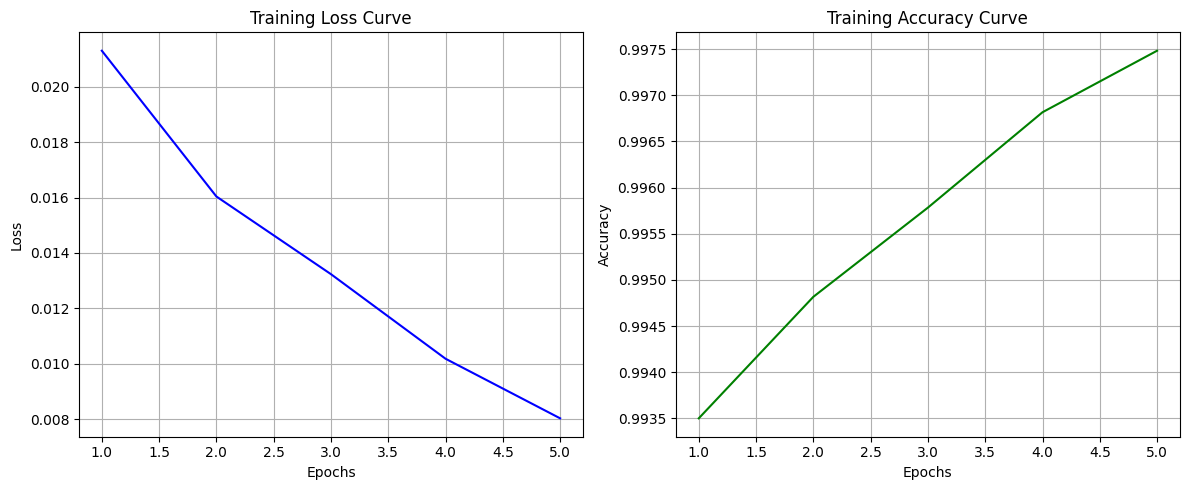

In [57]:
import matplotlib.pyplot as plt

# Lists to store loss and accuracy for plotting
losses = []
accuracies = []

epochs = 5
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        # Prepare data for model input
        inputs = inputs.squeeze(3)  # Remove the single color channel
        labels = torch.argmax(labels, dim=1)  # Convert labels to index format

        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Model prediction
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    losses.append(epoch_loss)  # Store loss for plotting
    accuracies.append(epoch_accuracy)  # Store accuracy for plotting

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# After training, plot the curves
plt.figure(figsize=(12, 5))

# Plot Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), losses, label='Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), accuracies, label='Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


In [55]:
# 评估模型
model.eval()  # 设置模型为评估模式
correct = 0
total = 0
with torch.no_grad():  # 关闭梯度计算
    for inputs, labels in test_loader:
        inputs = inputs.squeeze(3)
        labels = torch.argmax(labels, dim=1)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct/total:.4f}")


Test Accuracy: 0.0969
